# **Product Recommendation System: Refining AI-driven Recommendations Based on Browsing and Purchase History**

## **Step 1: Data Preparation & Preprocessing**

### **1.1 Import Required Libraries**
- Load pandas, numpy, matplotlib, seaborn for data processing and visualization.
- Use scipy, sklearn, and surprise for recommendation modeling.

### **1.2 Load and Merge Data**
#### **Import the following essential datasets:**
- orders.csv → To track customer purchases.
- order_items.csv → To link customers with purchased products.
- customers.csv → To associate orders with customers.
- products.csv → To extract product attributes.
- product_category_name_translation.csv → To translate product categories.

#### **Merge datasets to create a user-product interaction table.**

### **1.3 Data Cleaning**
- Handle missing values (drop or impute where necessary).
- Convert timestamps to datetime format.
- Normalize product attributes (e.g., price, weight).
- Convert categorical values (e.g., product category) into numeric format if required.


## **Step 2: Exploratory Data Analysis (EDA)**

### **2.1 Understand Customer Purchase Patterns**
- Find the most frequently purchased products.
- Analyze product categories to identify top-selling categories.
- Check customer purchasing behavior (one-time buyers vs. repeat buyers).




In [2]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Processing
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import warnings 
warnings.filterwarnings("ignore")


## Load and Merge Data
Datasets to Import
* orders.csv → Tracks customer purchases.
* order_items.csv → Links customers with purchased products.
* customers.csv → Associates orders with customers.
* products.csv → Provides product attributes.
* product_category_name_translation.csv → Translates product categories into English.

In [5]:
# Import datasets
orders = pd.read_csv("orders_cleaned.csv")
order_items = pd.read_csv("order_items_cleaned.csv")
customers = pd.read_csv('customers_cleaned.csv')
products = pd.read_csv('products_cleaned.csv') 
product_category= pd.read_csv('product_category_name_translation_cleaned.csv')

# Data Cleaning
Data cleaning steps to double check for data integrity

* Check for missing values and handle them.
* Convert timestamps to datetime format.
* Normalize product attributes (e.g., price, weight).
* Ensure correct data types for numerical and categorical variables.

In [7]:
# Display first few rows
print("Orders Data Sample:")
display(orders.head())

Orders Data Sample:


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [8]:
# Display data information
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [9]:
# check for missing values
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

# Clean Orders data
1. We fill order_approved_at with order_purchase_timestamp to maintain data integrity.
2. We drop order_delivered_carrier_date and order_delivered_customer_date because they are not relevant for recommendations.


In [22]:
# Convert timestamps in orders dataset
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"])
orders["order_approved_at"] = pd.to_datetime(orders["order_approved_at"])
orders["order_delivered_carrier_date"] = pd.to_datetime(orders["order_delivered_carrier_date"])
orders["order_delivered_customer_date"] = pd.to_datetime(orders["order_delivered_customer_date"])
orders["order_estimated_delivery_date"] = pd.to_datetime(orders["order_estimated_delivery_date"])

# Confirm conversion
print(orders.dtypes)


order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object


In [29]:
# Fill missing values in `order_approved_at` with order_purchase_timestamp
orders["order_approved_at"].fillna(orders["order_purchase_timestamp"], inplace=True)

# Drop columns not needed for recommendations
orders.drop(columns=["order_delivered_carrier_date", "order_delivered_customer_date"], inplace=True)

# Confirm changes
print("Remaining Missing Values in Orders DataFrame:")
display(orders.isnull().sum())


Remaining Missing Values in Orders DataFrame:


order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_estimated_delivery_date    0
dtype: int64

In [10]:
# Display first few rows
print("Order Items Data Sample:")
display(order_items.head())

Order Items Data Sample:


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [11]:
# Display data information
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [18]:
# check for missing values
order_items.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [28]:
# Convert timestamps in orders dataset
order_items["shipping_limit_date"] = pd.to_datetime(order_items["shipping_limit_date"])
# Confirm conversion
print(order_items.dtypes)


order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object


In [12]:
# Display first few rows
print("Customers Data Sample:")
display(customers.head())

Customers Data Sample:


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,Franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,Sao Bernardo Do Campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,Sao Paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,Mogi Das Cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,Campinas,SP


In [13]:
# Display data information
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [19]:
# check for missing values
customers.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [14]:
# Display first few rows
print("Products Data Sample:")
display(products.head())

Products Data Sample:


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4,625.0,20.0,17.0,13.0


In [15]:
# Display data information
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32951 non-null  object 
 2   product_name_lenght         32951 non-null  float64
 3   product_description_lenght  32951 non-null  float64
 4   product_photos_qty          32951 non-null  int64  
 5   product_weight_g            32951 non-null  float64
 6   product_length_cm           32951 non-null  float64
 7   product_height_cm           32951 non-null  float64
 8   product_width_cm            32951 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 2.3+ MB


In [20]:
# check for missing values
products.isnull().sum()

product_id                    0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
dtype: int64

In [ ]:
# Rename product_name_lenght (typo) to product_name_length
products.rename(columns={"product_name_lenght": "product_name_length"}, inplace=True)

# Rename product_description_lenght (typo) to product_name_length
products.rename(columns={"product_description_lenght": "product_description_length"}, inplace=True)

In [16]:
# Display first few rows
print("Product Category Translation Data Sample:")
display(product_category.head())

Product Category Translation Data Sample:


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [17]:
# Display data information
product_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [21]:
# check for missing values
product_category.isnull().sum()

product_category_name            0
product_category_name_english    0
dtype: int64

# Merging our data into 0ne dataframe 

In [42]:
# Merge orders with customers to associate customer_id with unique users
orders_customers = orders.merge(customers, on="customer_id", how="inner")

# Merge order_items with orders_customers to associate products with customer_id
orders_products = order_items.merge(orders_customers, on="order_id", how="inner")

# Merge products with orders_products to add product attributes
orders_products_details = orders_products.merge(products, on="product_id", how="left")

# Merge with category translation for readable categories
orders_products_details = orders_products_details.merge(
    product_category, on="product_category_name", how="left"
)

# Drop unnecessary columns
orders_products_details.drop(columns=["product_category_name"], inplace=True)

# Rename column for clarity
orders_products_details.rename(columns={"product_category_name_english": "product_category"}, inplace=True)

# Display merged data sample
print("Merged Data Sample:")
display(orders_products_details.head())

# Check final shape
print("Final Merged DataFrame Shape:", orders_products_details.shape)


Merged Data Sample:


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,customer_city,customer_state,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,Campos Dos Goytacazes,RJ,58.0,598.0,4,650.0,28.0,9.0,14.0,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,...,Santa Fe Do Sul,SP,56.0,239.0,2,30000.0,50.0,30.0,40.0,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,...,Para De Minas,MG,59.0,695.0,2,3050.0,33.0,13.0,33.0,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,...,Atibaia,SP,42.0,480.0,1,200.0,16.0,10.0,15.0,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,...,Varzea Paulista,SP,59.0,409.0,1,3750.0,35.0,40.0,30.0,garden_tools


Final Merged DataFrame Shape: (112650, 24)


In [44]:
orders_products_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   order_item_id                  112650 non-null  int64         
 2   product_id                     112650 non-null  object        
 3   seller_id                      112650 non-null  object        
 4   shipping_limit_date            112650 non-null  datetime64[ns]
 5   price                          112650 non-null  float64       
 6   freight_value                  112650 non-null  float64       
 7   customer_id                    112650 non-null  object        
 8   order_status                   112650 non-null  object        
 9   order_purchase_timestamp       112650 non-null  datetime64[ns]
 10  order_approved_at              112650 non-null  datetime64[ns]
 11  

In [45]:
# create a copy of the merged DataFrame
df = orders_products_details.copy()

In [53]:
# Check for missing values in the copied DataFrame
df.isnull().sum()

order_id                          0
order_item_id                     0
product_id                        0
seller_id                         0
shipping_limit_date               0
price                             0
freight_value                     0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                 0
order_estimated_delivery_date     0
customer_unique_id                0
customer_zip_code_prefix          0
customer_city                     0
customer_state                    0
product_name_lenght               0
product_description_lenght        0
product_photos_qty                0
product_weight_g                  0
product_length_cm                 0
product_height_cm                 0
product_width_cm                  0
product_category                 24
dtype: int64

In [55]:
# Find the most common product category
most_frequent_category = df["product_category"].mode()[0]
print(f"Most Frequent Product Category: {most_frequent_category}")


Most Frequent Product Category: bed_bath_table


In [56]:
# Fill missing values with the most frequent category
df["product_category"].fillna(most_frequent_category, inplace=True)

# Verify no missing values remain
print(df["product_category"].isnull().sum())  


0


In [57]:
# Select only numerical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Display the selected numerical columns
print("Numerical Columns in df:")
print(numerical_columns)


Numerical Columns in df:
Index(['order_item_id', 'price', 'freight_value', 'customer_zip_code_prefix',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm'],
      dtype='object')


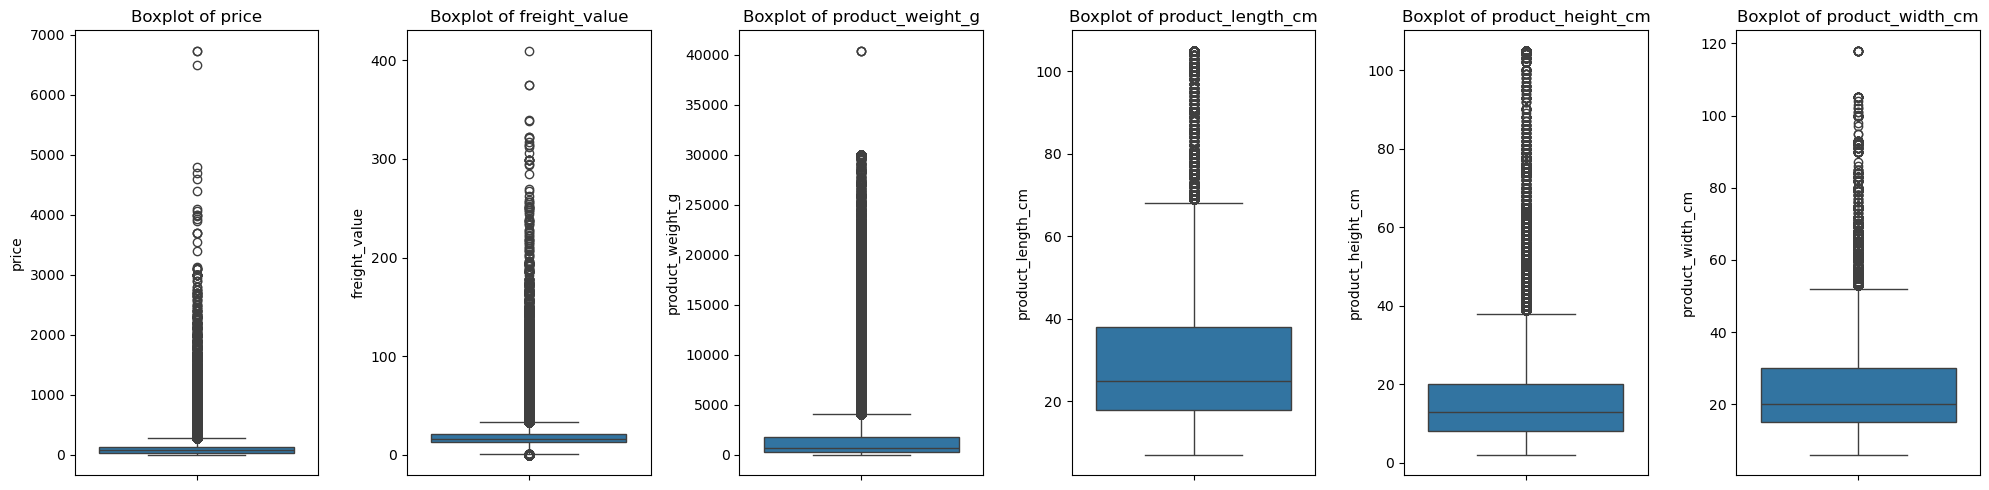

In [59]:
# check for outliers 
outlier_columns = ["price", "freight_value", "product_weight_g", "product_length_cm", "product_height_cm", "product_width_cm"]

# Step 2: Visualizing Outliers with Boxplots
fig, axes = plt.subplots(1, len(outlier_columns), figsize=(20, 5))
for i, col in enumerate(outlier_columns):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

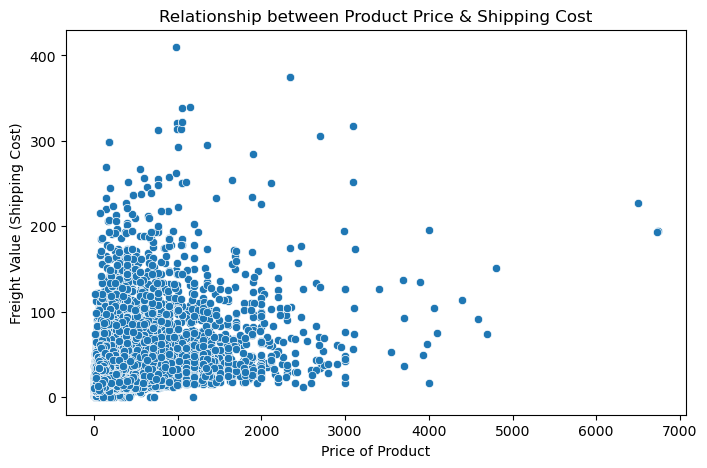

In [60]:
# Scatter plot to see relationship between price and freight_value
plt.figure(figsize=(8,5))
sns.scatterplot(x=df["price"], y=df["freight_value"])
plt.xlabel("Price of Product")
plt.ylabel("Freight Value (Shipping Cost)")
plt.title("Relationship between Product Price & Shipping Cost")
plt.show()


In [61]:
# Cap freight value at the 99th percentile
upper_freight = df["freight_value"].quantile(0.99)
df["freight_value"] = df["freight_value"].apply(lambda x: upper_freight if x > upper_freight else x)

# Confirm changes
print(f"Max Freight Value After Capping: {df['freight_value'].max()}")


Max Freight Value After Capping: 84.52


In [63]:
df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,customer_city,customer_state,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,Campos Dos Goytacazes,RJ,58.0,598.0,4,650.0,28.0,9.0,14.0,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,...,Santa Fe Do Sul,SP,56.0,239.0,2,30000.0,50.0,30.0,40.0,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,...,Para De Minas,MG,59.0,695.0,2,3050.0,33.0,13.0,33.0,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,...,Atibaia,SP,42.0,480.0,1,200.0,16.0,10.0,15.0,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,...,Varzea Paulista,SP,59.0,409.0,1,3750.0,35.0,40.0,30.0,garden_tools


# Exploratory data analysis
#### Understand Customer Purchase Patterns
* Find the most frequently purchased products. 
* Analyze product categories to identify top-selling categories.
* Check customer purchasing behavior (one-time buyers vs. repeat buyers).

## Find the Most Frequently Purchased Products

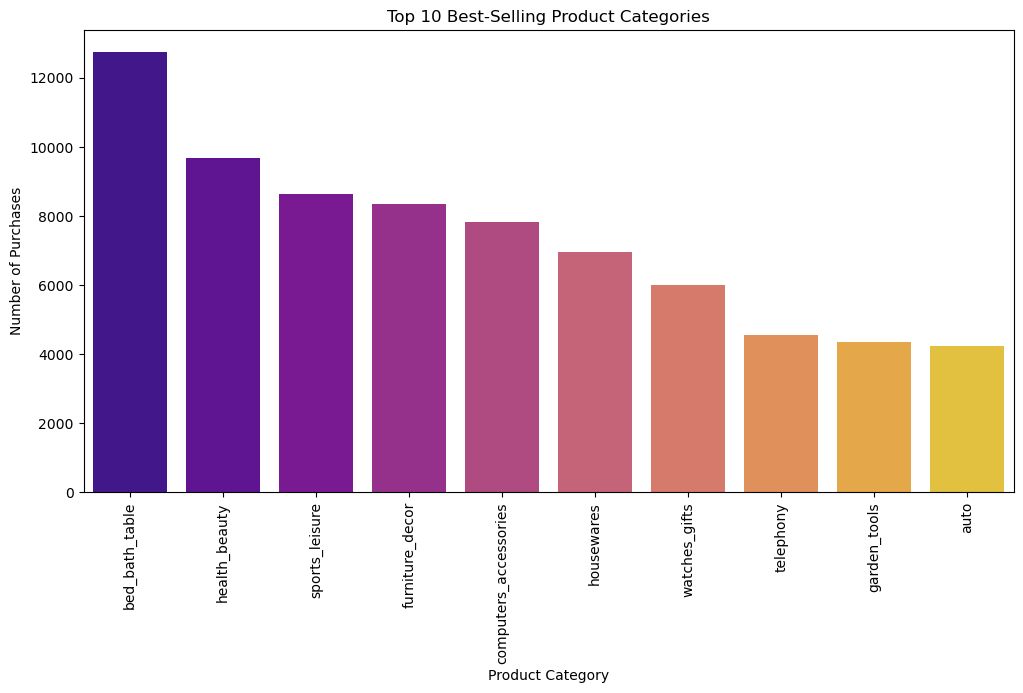

In [66]:
# Count purchases per product category
top_categories = df["product_category"].value_counts().head(10)

# Plot top-selling categories
plt.figure(figsize=(12, 6))
sns.barplot(x=top_categories.index, y=top_categories.values, palette="plasma")  
plt.ylabel("Number of Purchases")
plt.title("Top 10 Best-Selling Product Categories")
plt.xticks(rotation=90)
plt.show()



### Check Customer Purchasing Behavior (One-Time vs. Repeat Buyers)

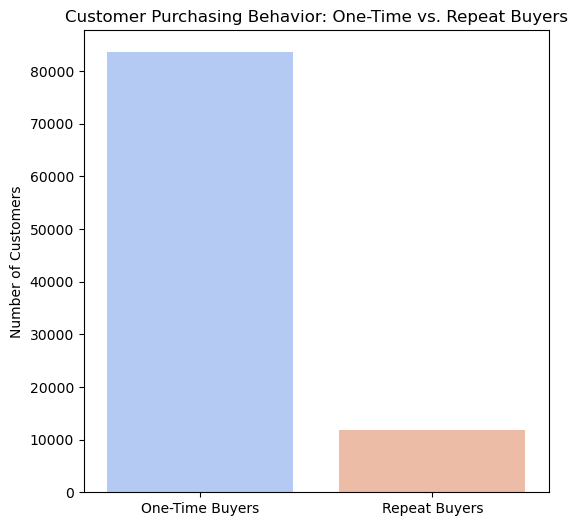

In [67]:
# Count purchases per unique customer
customer_purchases = df["customer_unique_id"].value_counts()

# Categorize customers
one_time_buyers = (customer_purchases == 1).sum()
repeat_buyers = (customer_purchases > 1).sum()

# Plot
plt.figure(figsize=(6, 6))
sns.barplot(x=["One-Time Buyers", "Repeat Buyers"], y=[one_time_buyers, repeat_buyers], palette="coolwarm")
plt.ylabel("Number of Customers")
plt.title("Customer Purchasing Behavior: One-Time vs. Repeat Buyers")
plt.show()


# Univariate Analysis Insights

## 1. Top 10 Best-Selling Product Categories
### Observations:
- Bed, Bath & Table is the most purchased category, significantly higher than others.
- Health & Beauty, Sports & Leisure, and Furniture & Decor are also among the top-selling categories.
- Tech-related products like Computers & Accessories and Telephony are present but not dominant.
- Auto and Garden Tools have lower purchases compared to household and personal care categories.

### Business Implication:
- Trafilea e-commerce platform likely serves a home & lifestyle-focused customer base.
- Marketing strategies could prioritize discounts or bundle offers in high-selling categories (e.g., Home Essentials & Beauty).
- Opportunity for cross-selling: Customers who buy Bed & Bath products may also be interested in Furniture & Decor.


## 2. Customer Purchasing Behavior: One-Time vs. Repeat Buyers
### Observations:
- A significant majority of customers (over 80,000) are one-time buyers.
- Only a small portion (around 10,000-15,000) are repeat buyers.

### Business Implication:
- High customer churn: Most buyers do not return for additional purchases.
- Retention Strategies Needed:
  - Loyalty programs or discounts for returning customers.
  - Personalized email marketing campaigns targeting past buyers.
  - Bundling strategies to increase customer lifetime value.



# Bivariate Analysis

### Key Questions for Bivariate Analysis:
1. Do repeat buyers purchase different categories than one-time buyers?  
2. Is there a relationship between product price and category popularity?  
3. How does purchase frequency vary across different price ranges?  


In [71]:
df.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'customer_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_estimated_delivery_date', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'product_category'],
      dtype='object')

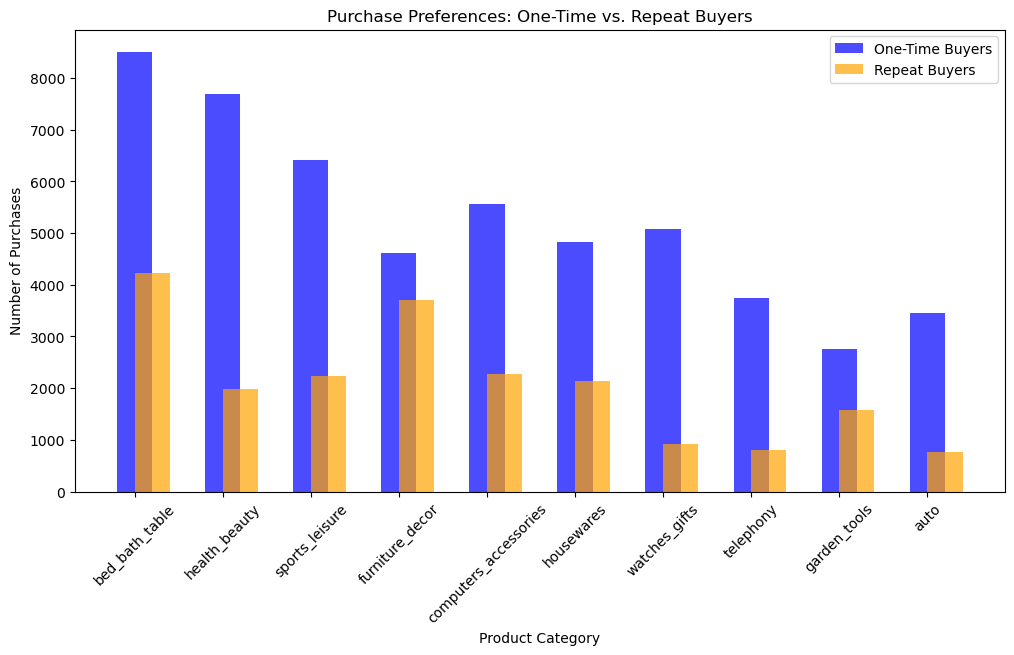

In [72]:
# Count purchases per customer
customer_purchases = df["customer_unique_id"].value_counts()

# Categorize customers
one_time_buyers = customer_purchases[customer_purchases == 1].index
repeat_buyers = customer_purchases[customer_purchases > 1].index

# Filter dataset by customer type
one_time_df = df[df["customer_unique_id"].isin(one_time_buyers)]
repeat_df = df[df["customer_unique_id"].isin(repeat_buyers)]

# Count purchases by product category for each group
top_categories = df["product_category"].value_counts().head(10).index
one_time_category_counts = one_time_df["product_category"].value_counts()[top_categories]
repeat_category_counts = repeat_df["product_category"].value_counts()[top_categories]

# Create side-by-side bar plots
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.4

# Plot One-Time Buyers
ax.bar(top_categories, one_time_category_counts, width=bar_width, label="One-Time Buyers", alpha=0.7, color="blue")

# Plot Repeat Buyers (Shift bars slightly for clarity)
ax.bar(top_categories, repeat_category_counts, width=bar_width, label="Repeat Buyers", alpha=0.7, color="orange", align="edge")

ax.set_xlabel("Product Category")
ax.set_ylabel("Number of Purchases")
ax.set_title("Purchase Preferences: One-Time vs. Repeat Buyers")
ax.legend()
plt.xticks(rotation=45)
plt.show()


 ### Is There a Relationship Between Product Price and Category Popularity?

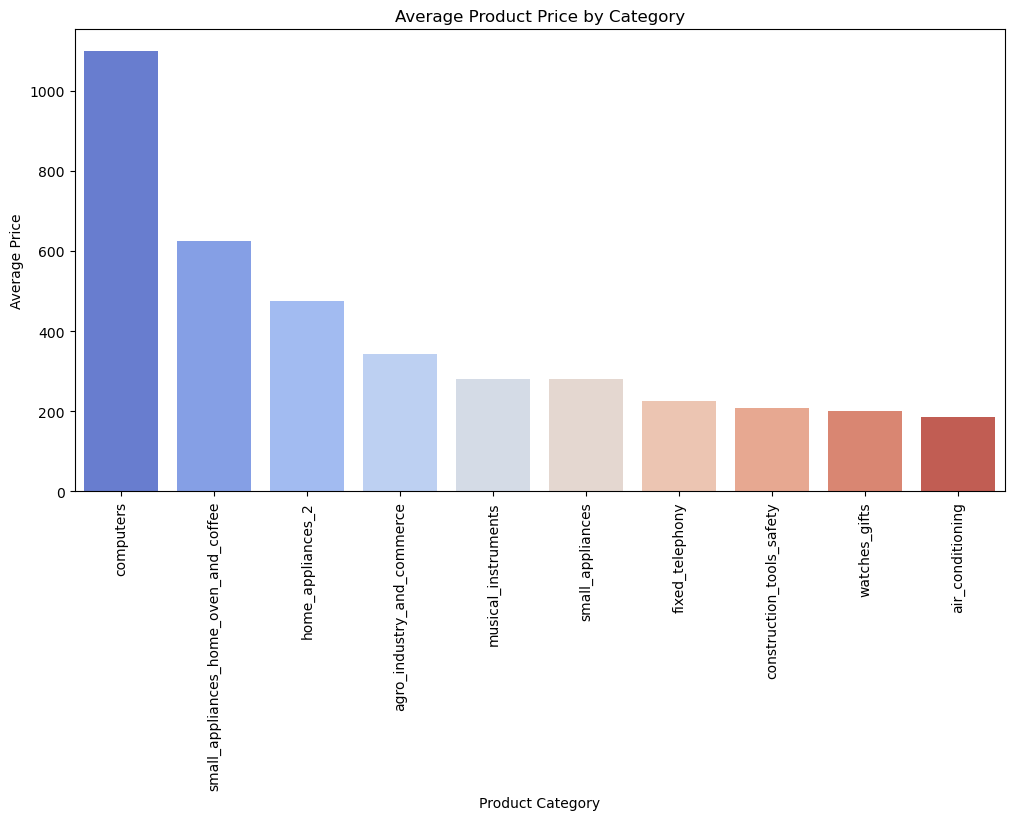

In [74]:
# Compute average price per category
price_by_category = df.groupby("product_category")["price"].mean().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=price_by_category.index, y=price_by_category.values, palette="coolwarm")
plt.xlabel("Product Category")
plt.ylabel("Average Price")
plt.title("Average Product Price by Category")
plt.xticks(rotation=90)
plt.show()


# Insights from the Charts

## 1. Average Product Price by Category

* **Computers have the highest average price**, making them premium products
* **Home appliances and musical instruments** also have relatively high average prices
* **Categories like watches, air conditioning, and construction tools** are in the mid-range

### Recommendation System Impact:
* **Premium products** (e.g., computers, home appliances) should be suggested only to customers with prior high-value purchases
* **More affordable categories** should be recommended to budget-conscious customers

## 2. Purchase Preferences: One-Time vs. Repeat Buyers

* **One-time buyers dominate purchases across all product categories**
* **Repeat buyers are most common in categories like furniture, decor, and bed/bath**
* **Fashion, health, and beauty categories attract a notable share of repeat buyers**

### Recommendation System Impact:
* **For one-time buyers,** suggest lower-risk, widely purchased products to encourage repeat shopping
* **For repeat buyers,** recommend products within their preferred categories to enhance retention

### How Does Purchase Frequency Vary Across Different Price Ranges?

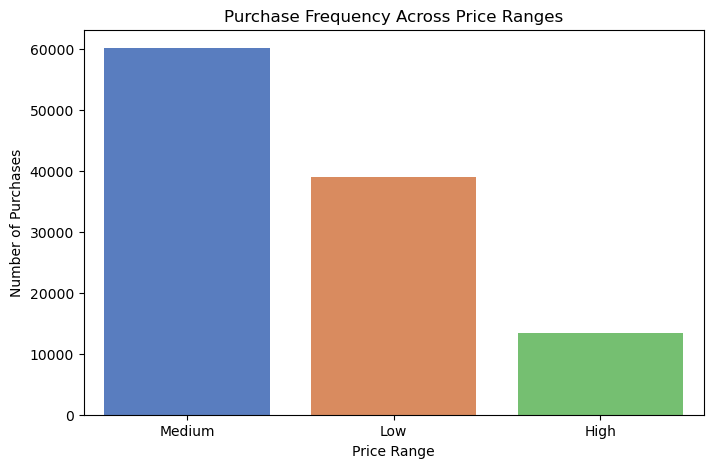

In [75]:
# Define price ranges
def price_category(price):
    if price < 50:
        return "Low"
    elif 50 <= price < 200:
        return "Medium"
    else:
        return "High"

df["price_range"] = df["price"].apply(price_category)

# Count purchases by price range
price_range_counts = df["price_range"].value_counts()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=price_range_counts.index, y=price_range_counts.values, palette="muted")
plt.xlabel("Price Range")
plt.ylabel("Number of Purchases")
plt.title("Purchase Frequency Across Price Ranges")
plt.show()


# Which price range has the highest purchase frequency?

The chart shows how frequently customers purchase products within each price range.
It provides insights into **consumer spending behavior** and **which price categories are the most popular**.

## Insights from the Chart

### 1. Medium-priced products have the highest purchase frequency
* This suggests that most customers prefer **moderately priced products over very cheap or very expensive ones**
* The **recommendation system should prioritize medium-priced products for most users**

### 2. Low-priced products have a significant number of purchases
* A considerable portion of purchases still occurs in the **low-price range**, indicating a **price-sensitive customer segment**
* The **recommendation model should also include budget-friendly options for customers who frequently purchase lower-cost items**

### 3. High-priced products have the lowest purchase frequency
* Customers **rarely buy high-priced items**, meaning **luxury items should not be widely recommended**
* The **system should only suggest expensive items to high-spending customers or those with previous high-value purchases**

## How Does This Help the Recommendation System?

* **Prioritize medium-priced items in general recommendations**
* **For customers who frequently buy low-priced items, suggest affordable alternatives**
* **Only recommend high-end products to customers with a history of buying expensive items**

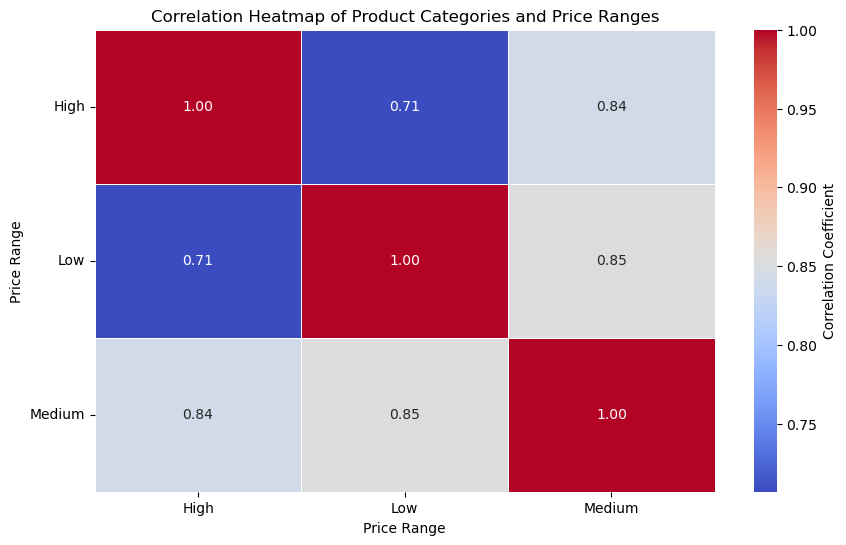

In [78]:
# Pivot table: Count of purchases per category per price range
category_price_heatmap = df.pivot_table(index="product_category", columns="price_range", values="order_id", aggfunc="count", fill_value=0)

# Compute correlation matrix
corr_matrix = category_price_heatmap.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})

plt.xlabel("Price Range")
plt.ylabel("Price Range")
plt.title("Correlation Heatmap of Product Categories and Price Ranges")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()


# Do different price ranges appear together across product categories?

The heatmap shows how **strongly different price ranges are correlated** in terms of their purchase frequency across categories.

* A **high correlation** between two price ranges (e.g., Medium and Low with 0.85) suggests that **customers who buy in one price range are also likely to buy in another**
* A **low correlation** (e.g., High and Low at 0.71) indicates that purchases in these price segments do not frequently occur together

## Insights from the Heatmap

### 1. Medium and Low price ranges are the most correlated (0.85)
* Suggests that **customers who buy lower-priced items also tend to buy medium-priced items**
* The **recommendation system should suggest medium-priced products to customers who typically purchase lower-priced items**

### 2. High price range is weakly correlated with Low price range (0.71)
* Customers buying high-priced items do not frequently purchase low-priced items
* The **recommendation system should avoid suggesting very cheap products to high-value buyers**

### 3. Medium price range has a strong correlation with both Low and High price ranges
* This suggests that **customers who purchase medium-priced items are more flexible in their spending**
* The **recommendation system should balance suggestions between medium and high/low-priced items based on the user's previous spending patterns**

## How Does This Help the Recommendation System?

* **If a customer frequently buys from the Low price range, recommend Medium-priced products**
* **If a customer buys from the High price range, avoid recommending Low-priced products**
* **For Medium-price buyers, offer a mix of both High and Low-priced recommendations**

# Multivariate Analysis

To analyze how multiple factors interact in customer behavior and product sales.

1. How do price, product category, and purchase frequency relate?
2. .Are repeat buyers more likely to purchase high-priced products in certain categories?
3. How does order volume vary across different product categories and price ranges?


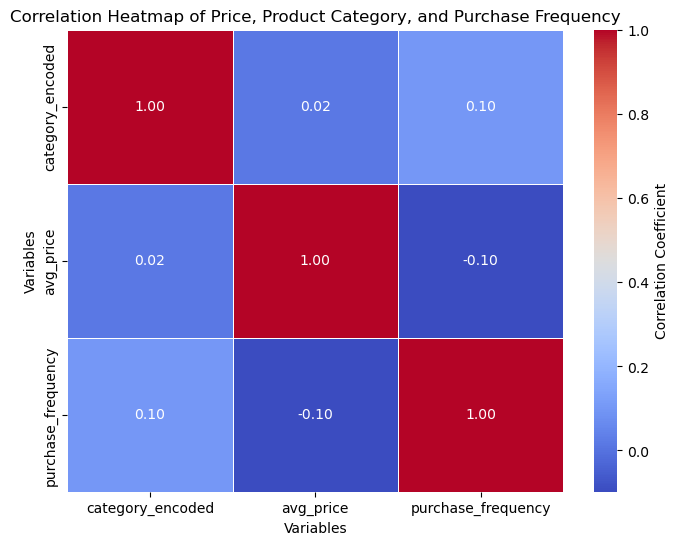

In [80]:
# Convert product categories to numeric labels for correlation
df["category_encoded"] = df["product_category"].astype("category").cat.codes

# Group data to get average price and purchase frequency per category
category_price_corr = df.groupby("category_encoded").agg(
    avg_price=("price", "mean"),
    purchase_frequency=("order_id", "count")
).reset_index()

# Compute correlation matrix
corr_matrix = category_price_corr.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})

plt.xlabel("Variables")
plt.ylabel("Variables")
plt.title("Correlation Heatmap of Price, Product Category, and Purchase Frequency")
plt.show()



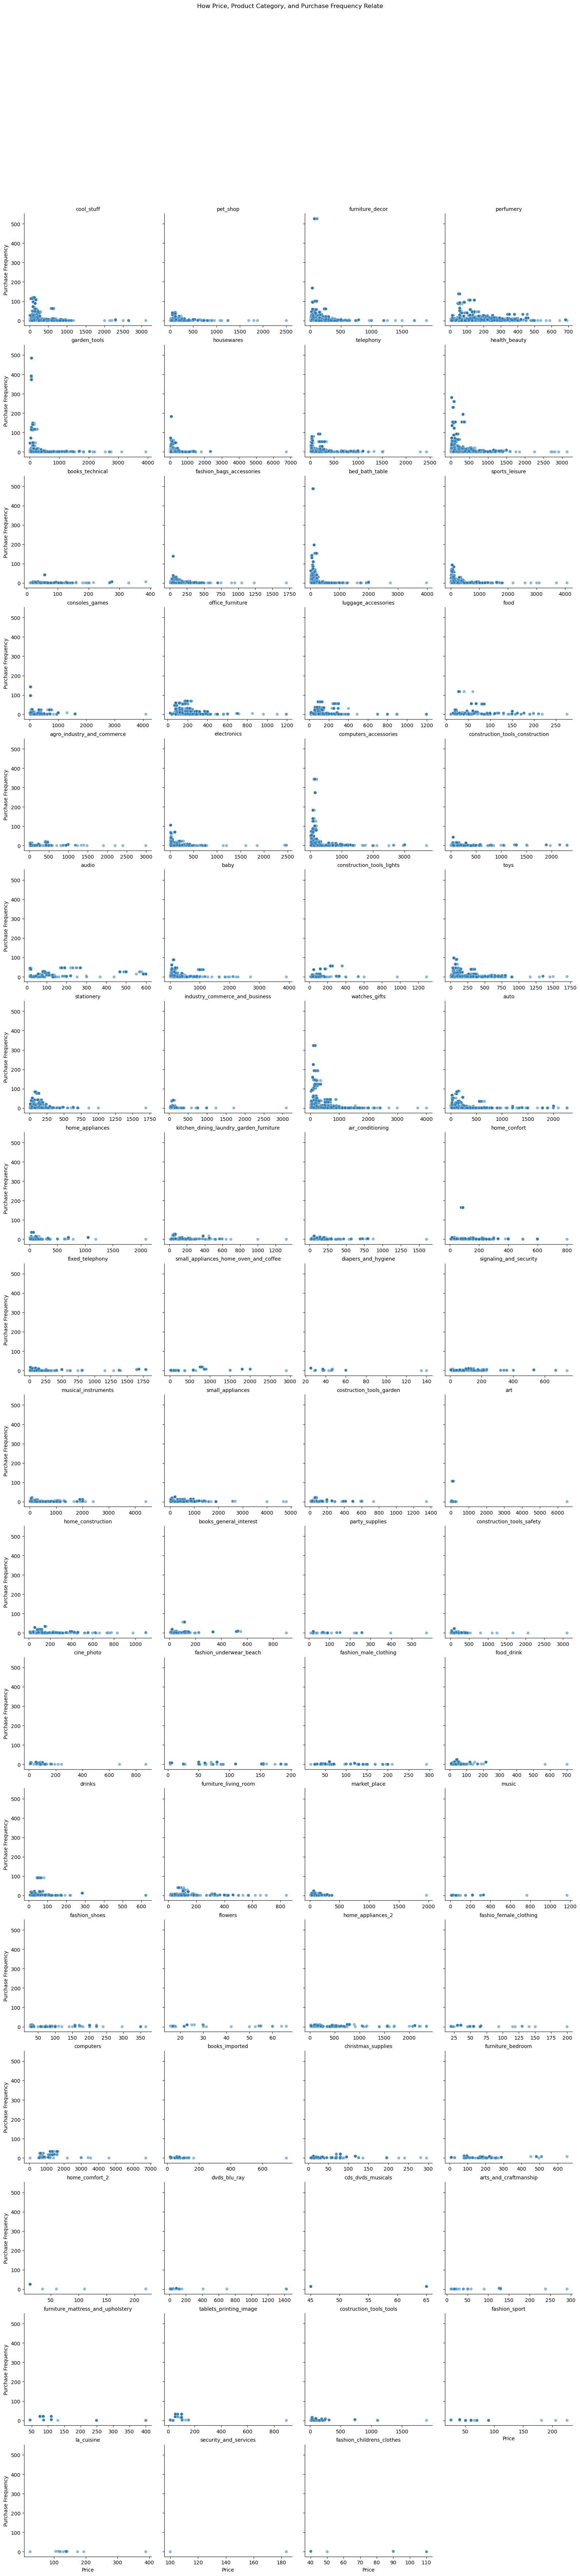

In [82]:
# Count purchase frequency per product
df["purchase_count"] = df.groupby("product_id")["order_id"].transform("count")

# Create a Facet Grid with scatter plots per category
g = sns.FacetGrid(df, col="product_category", col_wrap=4, height=4, sharex=False, sharey=True)
g.map_dataframe(sns.scatterplot, x="price", y="purchase_count", alpha=0.5)

# Adjust layout
g.set_axis_labels("Price", "Purchase Frequency")
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("How Price, Product Category, and Purchase Frequency Relate")
plt.show()


# Insights from Facet Grid Scatter Plots: Price vs. Purchase Frequency per Category

The Facet Grid scatter plots provide a detailed view of how price, product category, and purchase frequency relate. Below are the key findings:

## Most Purchases Happen at Lower Price Points
* Across all categories, purchases are concentrated in the lower price ranges, mostly below 500
* Higher-priced items have significantly fewer purchases, meaning customers tend to prefer affordable options
* Price plays a crucial role in purchasing behavior

## Different Categories Show Unique Purchasing Trends
* Categories like electronics, fashion, and home decor exhibit a wide spread of price points, but purchases remain concentrated in lower price brackets
* Luxury categories such as watches, gifts, and high-end electronics have low purchase frequency at high price points, indicating they are niche products for specific buyers

## Some Categories Have a Balanced Price Distribution
* Categories like furniture and garden tools show reasonable purchase counts across mid-to-high price ranges, suggesting customers are willing to spend more
* Fashion and cosmetics remain dominated by low-cost purchases

## Highly Expensive Items Are Rarely Purchased
* Across all categories, products priced above 2,000 show very few purchases
* High-end items should not be recommended broadly but rather to specific high-spending customers

## Final Insights to Improve Recommendations
* Use price as a filtering criterion and prioritize lower-cost recommendations unless the user has purchased expensive products
* Customize recommendations per category to match customer spending behavior
* Apply customer segmentation so high-priced items are only recommended to users who have shown interest in similar products

## Next Steps
* Incorporate customer purchase history into the recommendation model
* Develop a hybrid recommendation system combining collaborative filtering and content-based filtering
* Implement dynamic price filtering to match user spending habits
 
